# Homework06

Exercises to practice pandas, data analysis and regression

## Goals

- Understand the effects of pre-processing data
- Get familiar with the ML flow: encode -> normalize -> train -> evaluate
- Understand the difference between regression and classification tasks
- Build intuition for different regression models

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [47]:
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/data_utils.py

In [46]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import OrdinalEncoder

from data_utils import object_from_json_url
from data_utils import StandardScaler
from data_utils import LinearRegression, SGDRegressor
from data_utils import regression_error

### Load Dataset

Let's load up the full [ANSUR](https://www.openlab.psu.edu/ansur2/) dataset that we looked at briefly in [Week 02](https://github.com/DM-GY-9103-2024F-H/WK02).

This is the dataset that has anthropometric information about U.S. Army personnel.

#### WARNING

Like we mentioned in class, this dataset is being used for these exercises due to the level of detail in the dataset and the rigorous process that was used in collecting the data.

This is a very specific dataset and should not be used to draw general conclusions about people, bodies, or anything else that is not related to the distribution of physical features of U.S. Army personnel.

In [3]:
# Load Dataset
ANSUR_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025S-A/5020-utils/main/datasets/json/ansur.json"
ansur_data = object_from_json_url(ANSUR_FILE)

# Look at first 2 records
ansur_data[:2]

[{'age': 18,
  'gender': 'F',
  'height': 66,
  'weight': 135,
  'span': 1699,
  'stature': 1645,
  'ear': {'breadth': 30, 'length': 61, 'protrusion': 20},
  'foot': {'breadth': 97, 'length': 243},
  'hand': {'breadth': 78, 'length': 182, 'palm': 108},
  'head': {'height': 243, 'circumference': 557}},
 {'age': 30,
  'gender': 'M',
  'height': 68,
  'weight': 207,
  'span': 1749,
  'stature': 1715,
  'ear': {'breadth': 35, 'length': 63, 'protrusion': 17},
  'foot': {'breadth': 100, 'length': 252},
  'hand': {'breadth': 87, 'length': 184, 'palm': 114},
  'head': {'height': 238, 'circumference': 560}}]

#### Nested data

This is that *nested* dataset from Week 02.

# 🤔

Let's load it into a `DataFrame` to see what happens.

In [4]:
# Read into DataFrame
ansur_df = pd.DataFrame.from_records(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear,foot,hand,head
0,18,F,66,135,1699,1645,"{'breadth': 30, 'length': 61, 'protrusion': 20}","{'breadth': 97, 'length': 243}","{'breadth': 78, 'length': 182, 'palm': 108}","{'height': 243, 'circumference': 557}"
1,30,M,68,207,1749,1715,"{'breadth': 35, 'length': 63, 'protrusion': 17}","{'breadth': 100, 'length': 252}","{'breadth': 87, 'length': 184, 'palm': 114}","{'height': 238, 'circumference': 560}"
2,27,M,67,121,1684,1657,"{'breadth': 36, 'length': 59, 'protrusion': 24}","{'breadth': 92, 'length': 251}","{'breadth': 84, 'length': 180, 'palm': 103}","{'height': 239, 'circumference': 516}"
3,20,M,73,185,1878,1828,"{'breadth': 36, 'length': 60, 'protrusion': 21}","{'breadth': 104, 'length': 280}","{'breadth': 95, 'length': 201, 'palm': 124}","{'height': 270, 'circumference': 582}"
4,33,M,76,150,1977,1883,"{'breadth': 39, 'length': 65, 'protrusion': 27}","{'breadth': 101, 'length': 271}","{'breadth': 90, 'length': 194, 'palm': 113}","{'height': 254, 'circumference': 559}"



# 😓🙄

That didn't work too well. We ended up with objects in our columns.

Luckily, our `DataFrame` library has a function called [`json_normalize()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html) that can help.

In [5]:
# Read into DataFrame
ansur_df = pd.json_normalize(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference
0,18,F,66,135,1699,1645,30,61,20,97,243,78,182,108,243,557
1,30,M,68,207,1749,1715,35,63,17,100,252,87,184,114,238,560
2,27,M,67,121,1684,1657,36,59,24,92,251,84,180,103,239,516
3,20,M,73,185,1878,1828,36,60,21,104,280,95,201,124,270,582
4,33,M,76,150,1977,1883,39,65,27,101,271,90,194,113,254,559


Much better. `DataFrames` are magic.

#### Data Exploration

Before we start creating models, let's do a little bit of data analysis and get a feeling for the shapes, distributions and relationships of our data.

1. Print `min`, `max` and `average` values for all of the features.
2. Print `covariance` tables for `age`, `ear.length` and `head.circumference`.
3. Plot `age`, `ear.length` and `head.circumference` versus the $1$ *feature* that is most correlated to each of them.

Don't forget to *encode* and *normalize* the data.

Min values:
 age                     17.0
gender                   NaN
height                  56.0
weight                   0.0
span                  1323.0
stature               1409.0
ear.breadth             25.0
ear.length              46.0
ear.protrusion          13.0
foot.breadth            77.0
foot.length            198.0
hand.breadth            67.0
hand.length            145.0
hand.palm               88.0
head.height            206.0
head.circumference     502.0
dtype: float64

Max values:
 age                     58.0
gender                   NaN
height                  94.0
weight                 321.0
span                  2121.0
stature               1993.0
ear.breadth             46.0
ear.length              81.0
ear.protrusion          34.0
foot.breadth           126.0
foot.length            323.0
hand.breadth           105.0
hand.length            239.0
hand.palm              140.0
head.height            295.0
head.circumference     635.0
dtype: float64

Average values

/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


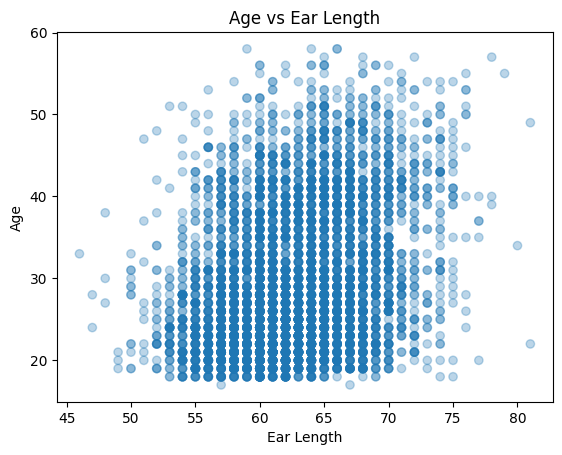

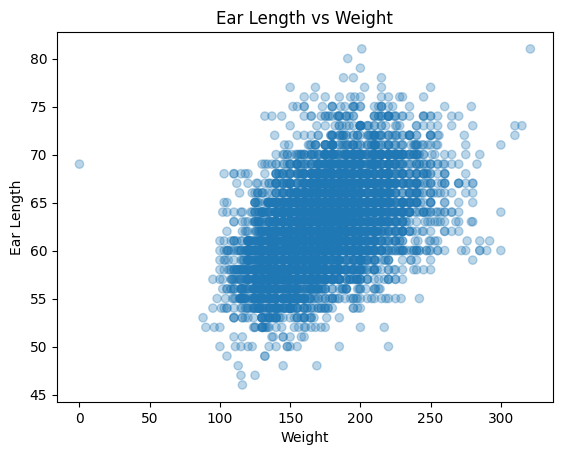

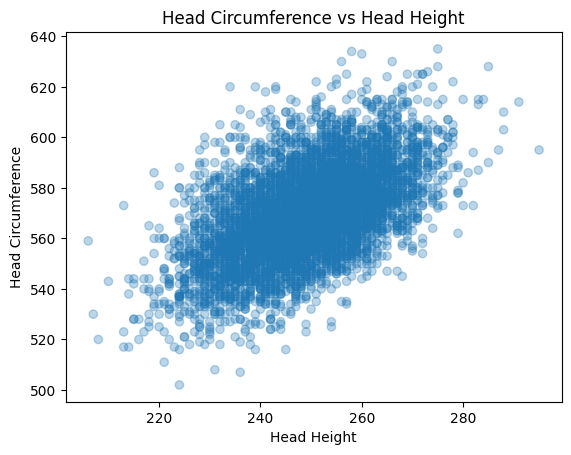

In [ ]:
# Work on Data Exploration here

### Encode non-numerical features
#Hey Thiago, had a lot of trouble encoding the data with the method we saw in class. Kept getting an error so found this way of mapping them manually.
gender_order = ['F', 'M']
ansur_encoder = OrdinalEncoder(categories=[gender_order])
ansur_df['gender'] = ansur_df['gender'].map({'F': 0, 'M': 1})
## 1. Print min, max, avg
print("Min values:\n", ansur_df.min(numeric_only=True))
print("\nMax values:\n", ansur_df.max(numeric_only=True))
print("\nAverage values:\n", ansur_df.mean(numeric_only=True))
### Normalize all data
ansur_scaler = StandardScaler()
ansur_scaled = ansur_scaler.fit_transform(ansur_df)
ansur_scaled_df = pd.DataFrame(ansur_scaled, columns=ansur_df.columns)
## 2. Print Covariances
print("\nCovariance matrix:\n", ansur_scaled_df.cov())
## 3. Plot features most correlated to age, ear length and head circumference
# Used the matrix I added under to determine the following graphs :)
plt.scatter(ansur_df['ear.length'], ansur_df['age'], marker='o', linestyle='', alpha=0.3)
plt.xlabel("Ear Length")
plt.ylabel("Age")
plt.title("Age vs Ear Length")
plt.show()
plt.scatter(ansur_df['weight'], ansur_df['ear.length'], marker='o', linestyle='', alpha=0.3)
plt.xlabel("Weight")
plt.ylabel("Ear Length")
plt.title("Ear Length vs Weight")
plt.show()
plt.scatter(ansur_df['head.height'], ansur_df['head.circumference'], marker='o', linestyle='', alpha=0.3)
plt.xlabel("Head Height")
plt.ylabel("Head Circumference")
plt.title("Head Circumference vs Head Height")
plt.show()

In [100]:
print(ansur_df['gender'].unique())

[0. 1.]


In [101]:
corr_matrix = ansur_df.corr(numeric_only=True)
print(corr_matrix)

                         age    gender    height    weight      span  \
age                 1.000000  0.062190  0.029462  0.216979  0.064293   
gender              0.062190  1.000000  0.656517  0.562268  0.648191   
height              0.029462  0.656517  1.000000  0.659472  0.868948   
weight              0.216979  0.562268  0.659472  1.000000  0.662710   
span                0.064293  0.648191  0.868948  0.662710  1.000000   
stature             0.037965  0.663216  0.959816  0.682465  0.899239   
ear.breadth         0.187706  0.410426  0.355247  0.361917  0.348221   
ear.length          0.292046  0.463457  0.421835  0.487394  0.401492   
ear.protrusion     -0.009253  0.412980  0.283802  0.242238  0.268181   
foot.breadth        0.064981  0.641107  0.661963  0.708632  0.680895   
foot.length         0.048690  0.668959  0.820040  0.688105  0.862652   
hand.breadth        0.133806  0.745917  0.712069  0.710537  0.731443   
hand.length         0.104623  0.495221  0.736132  0.599787  0.84

### Interpretation

<span style="color:hotpink;">
Does anything stand out about these graphs? Or the correlations?<br>
Are correlations symmetric? Does the feature most correlated to ear length also have ear length as its most correlated pair?
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>

### Regression

Now, we want to create a regression model to predict `head.circumference` from the data.

From our [Week 06](https://github.com/PSAM-5020-2025S-A/WK06) notebook, we can create a regression model by following these steps:

1. Load dataset (done! 🎉)
2. Encode label features as numbers (done! ⚡️)
3. Normalize the data (done! 🍾)
4. Separate the outcome variable and the input features
5. Create a regression model using all features
6. Run model on training data and measure error
7. Plot predictions and interpret results
8. Run model on test data, measure error, plot predictions, interpret results

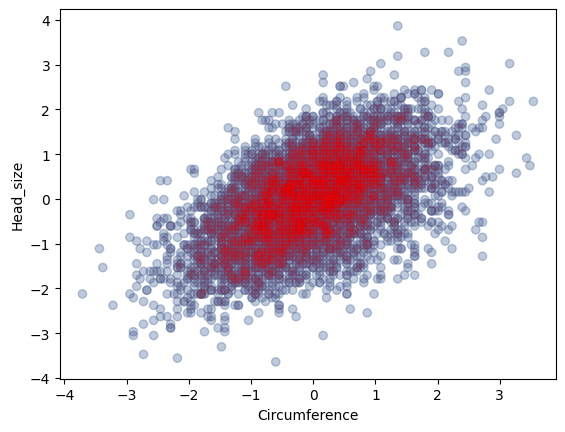

In [ ]:
# Work on Regression Model here

## Separate outcome variable and input features
head_size = ansur_scaled"]
circumference = ansur_scaled_df[["head.circumference"]]
## Create a regression model
head_size_model = LinearRegression()
head_size_model.fit(circumference, head_size)
predicted_scaled = head_size_model.predict(circumference)
regression_error(ansur_df["head.height"], predicted["head.height"])
## Plot predictions and interpret results
# Plot the original values
plt.scatter(circumference, head_size, marker='o', linestyle='', alpha=0.3)
plt.xlabel("Circumference")
plt.ylabel("Head_size")

# Plot the predictions
plt.scatter(circumference, head_size, color='r', marker='o', linestyle='', alpha=0.05)
plt.xlabel("Circumference")
plt.ylabel("Head_size")
plt.show()

In [109]:
## Load Test Data
ANSUR_TEST_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025S-A/5020-utils/main/datasets/json/ansur-test.json"

ansur_test_data = object_from_json_url(ANSUR_TEST_FILE)
ansur_test_df = pd.json_normalize(ansur_test_data)

ansur_test_encoded_df = ansur_test_df.copy()

ansur_test_encoded_df = ansur_test_df.copy()
ansur_test_encoded_df['gender'] = ansur_test_df['gender'].map({'F': 0, 'M': 1})

ansur_test_scaled_df = ansur_scaler.transform(ansur_test_encoded_df)

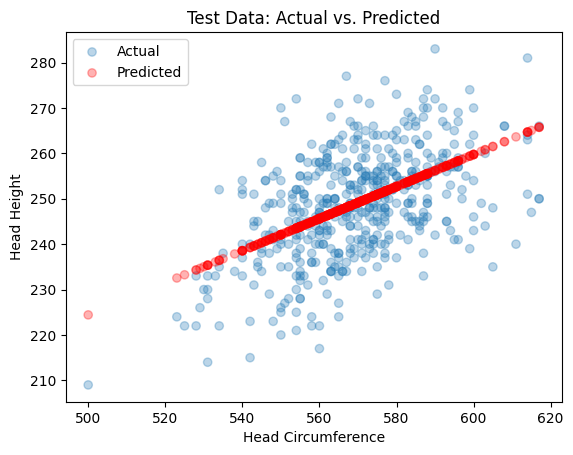

In [ ]:
## Run model on test data
test_circumference = ansur_test_scaled_df[["head.circumference"]]
test_pred_scaled = head_size_model.predict(test_circumference)

## Measure error on test data
test_copy = ansur_test_scaled_df.copy()
test_copy["head.height"] = test_pred_scaled
test_inverse = ansur_scaler.inverse_transform(test_copy)
predicted_test_df = pd.DataFrame(test_inverse, columns=ansur_test_scaled_df.columns)

regression_error(ansur_test_df["head.height"], predicted_test_df["head.height"])

plt.scatter(
    ansur_test_df["head.circumference"], 
    ansur_test_df["head.height"],
    marker='o', linestyle='', alpha=0.3, label="Actual"
)
plt.scatter(
    ansur_test_df["head.circumference"], 
    predicted_test_df["head.height"],
    color='r', marker='o', linestyle='', alpha=0.3, label="Predicted"
)
plt.xlabel("Head Circumference")
plt.ylabel("Head Height")
plt.title("Test Data: Actual vs. Predicted")
plt.legend()
plt.show()


### Interpretation

<span style="color:hotpink;">
How well does your model perform?<br>
How could you improve it?<br>
Are there ranges of circumferences that don't get predicted well?<br>

The predictions match overall positive correlation of the data. It could be improved by adding more features
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>